# Kernel-based Time-varying Regression - Part IV

We will continue to cover advance inputs for KTR. For other details you can also refer to the original paper Ng, Wang and Dai (2021).

In **Part IV**, we will cover advance inputs for regression including

- regressors signs
- adjusting knot sensitivity with respect to volume of response
- time-point coefficients priors 

In [3]:
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt

import orbit
from orbit.models import KTR
from orbit.diagnostics.plot import plot_predicted_components
from orbit.utils.plot import get_orbit_style

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.5f' % x)
orbit_style = get_orbit_style()
plt.style.context(orbit_style);

In [ ]:
def sim_data_grw(n, RS, p=3):
    """ coefficients curve are geometric random walk like
    """
    np.random.seed(RS)
    beta_init = np.concatenate(( 
        np.random.normal(2.0, 1.0, size = (1, 1)), # leves
        np.random.normal(-3.0, 0.05, size = (1, p)) # regression coefficients
    ), axis=-1) 

    beta_drift = np.random.normal(0.0, 0.05, size=(n-1, p + 1)) # drift

    beta = np.concatenate((beta_init, beta_drift), axis=0)

    # geometric random walk
    beta = np.exp(np.cumsum(beta, 0))

    # simulate regressors
    covar_lev = np.ones((n, 1))
    covar = np.concatenate((covar_lev, np.random.normal(0, 10.0, (n, p))), axis=1)

    # observation with noise
    y = (covar * beta).sum(-1) + 0.3 * np.random.normal(0, 1, n)

    regressor_col = ['x{}'.format(pp) for pp in range(1, p + 1)]
    regressor_col
    data = pd.DataFrame(covar[:, 1:], columns=regressor_col)
    beta_col = ['beta{}'.format(pp) for pp in range(1, p+1)]
    beta_data = pd.DataFrame(beta[:, 1:], columns=beta_col)
    data = pd.concat([data, beta_data], axis=1)

    data['y'] = y
    data['date'] = pd.date_range(start='1/1/2018', periods=len(y))
    
    return data

In [151]:
from orbit.utils.kernels import gauss_kernel

tp = np.arange(1, 301) / 300
knot_tp = np.array([1, 100, 300]) / 300
beta_knot = np.array(
    [[1.0, 0.1],
     [3.0, 0.03],
     [2.0, 0.05]]
)

gk = gauss_kernel(tp, knot_tp)

In [147]:
gk.shape

(300, 3)

In [155]:
beta = np.matmul(gk, beta_knot)
beta.shape

(300, 2)

In [156]:
covar_lev = np.ones((n, 1))
covar = np.concatenate((covar_lev, np.random.normal(0, 10.0, (n, 1))), axis=1)

In [159]:
# observation with noise
y = (covar * beta).sum(-1) + 0.3 * np.random.normal(0, 1, n)

In [144]:
data = sim_stepwise_coef_data(n=500, RS=2021, p=3, n_jump=2)
data.tail(10)

,x1,x2,x3,y,date,beta1,beta2,beta3
490,-14.33541,0.22069,-6.53724,2.71568,2019-05-06,0.14029,0.12924,0.11788
491,-8.99550,0.50170,2.97651,3.85878,2019-05-07,0.14029,0.12924,0.11788
492,-3.42616,-21.20118,-10.92106,0.59704,2019-05-08,0.14029,0.12924,0.11788
493,12.55181,-2.65334,-7.26496,5.75517,2019-05-09,0.14029,0.12924,0.11788
494,-1.33951,-5.99392,-1.15583,4.07413,2019-05-10,0.14029,0.12924,0.11788
495,-0.75232,4.55471,8.19088,6.48680,2019-05-11,0.14029,0.12924,0.11788
496,8.98932,8.02113,8.42241,8.59521,2019-05-12,0.14029,0.12924,0.11788
497,-2.65741,-14.34493,4.47058,3.67713,2019-05-13,0.14029,0.12924,0.11788
498,1.50937,0.56315,7.73681,6.32029,2019-05-14,0.14029,0.12924,0.11788
499,19.57613,-8.78261,5.49574,7.40127,2019-05-15,0.14029,0.12924,0.11788


<AxesSubplot:>

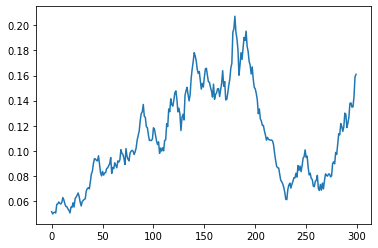

In [133]:
data['beta1'].plot()

In [134]:
# num of predictors
p = 3
regressor_col = ['x{}'.format(pp) for pp in range(1, p + 1)]
response_col = 'y'
date_col='date'

Here, we need to supply additional args to describe the regressors.

In [135]:
ktr = KTR(
    response_col=response_col,
    date_col=date_col,
    regressor_col=regressor_col,
    regressor_init_knot_scale=[0.1] * 3,
    regressor_knot_scale=[0.1] * 3,
    prediction_percentiles=[2.5, 97.5],
    seed=2021,
    estimator='pyro-svi',
)
ktr.fit(df=data)

INFO:root:Guessed max_plate_nesting = 1


## Visualization of Regression Coefficient Curves

First, we can leverage `get_regression_coefs` to extract coefficients with intervals by supplying argument `include_ci=True`.

In [136]:
coef_mid, coef_lower, coef_upper  = ktr.get_regression_coefs(include_ci=True)

Let's overlay the estimate with the true coefficients.

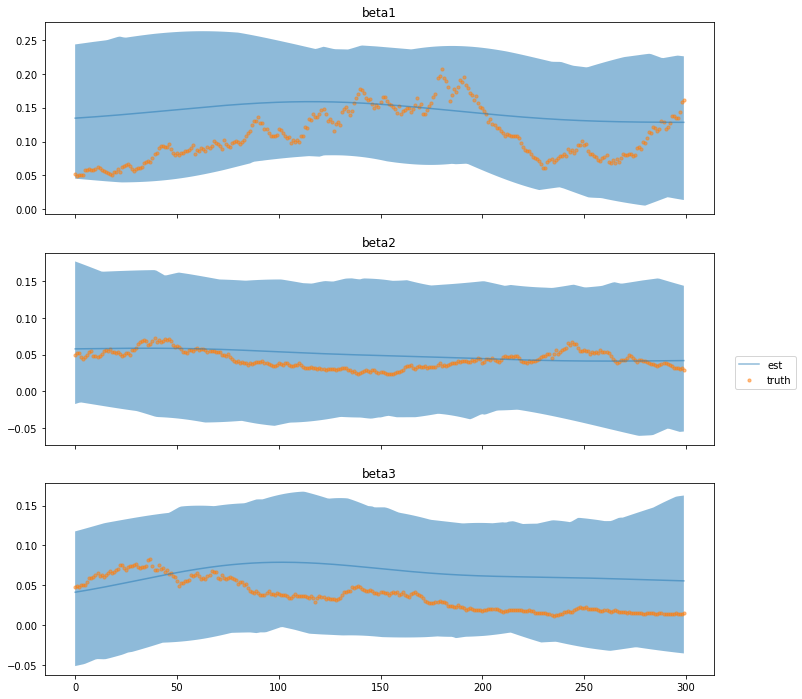

In [137]:
fig, axes = plt.subplots(p, 1, figsize=(12, 12), sharex=True)

x = np.arange(coef_mid.shape[0])
for idx in range(p):
    axes[idx].plot(x, coef_mid['x{}'.format(idx + 1)], label='est' if idx == 0 else "", alpha=0.5)
    axes[idx].fill_between(x, coef_lower['x{}'.format(idx + 1)], coef_upper['x{}'.format(idx + 1)], alpha=0.5)
    axes[idx].scatter(x, data['beta{}'.format(idx + 1)], label='truth' if idx == 0 else "", s=10, alpha=0.5)
    axes[idx].set_title('beta{}'.format(idx + 1))

fig.legend(bbox_to_anchor = (1,0.5));

In [141]:
ktr = KTR(
    response_col=response_col,
    date_col=date_col,
    regressor_col=regressor_col,
    regressor_sign=['+'] * 3,
    regressor_init_knot_scale=[0.1] * 3,
    regressor_knot_scale=[0.1] * 3,
    prediction_percentiles=[2.5, 97.5],
    seed=2021,
    estimator='pyro-svi',
)
ktr.fit(df=data)

INFO:root:Guessed max_plate_nesting = 1


In [142]:
coef_mid, coef_lower, coef_upper  = ktr.get_regression_coefs(include_ci=True)

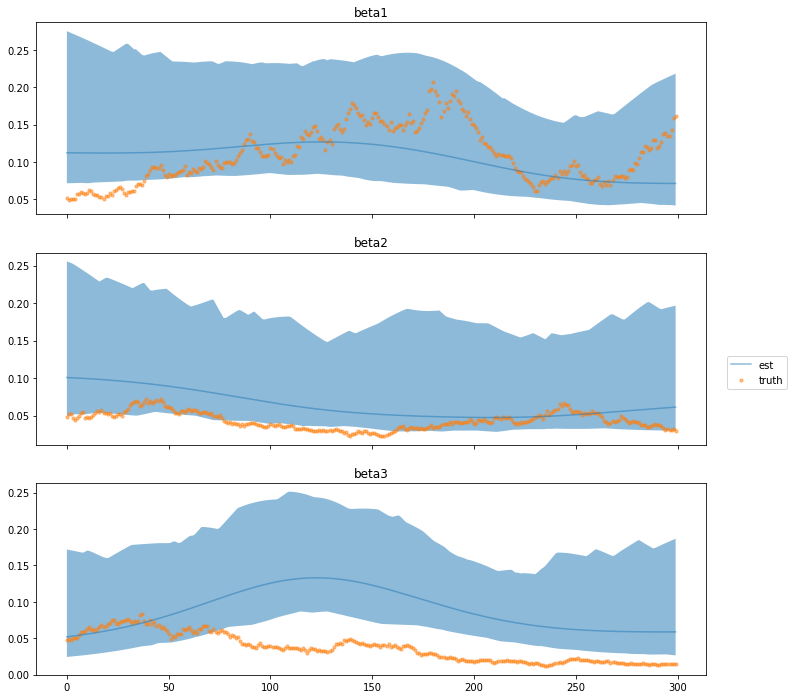

In [143]:
fig, axes = plt.subplots(p, 1, figsize=(12, 12), sharex=True)

x = np.arange(coef_mid.shape[0])
for idx in range(p):
    axes[idx].plot(x, coef_mid['x{}'.format(idx + 1)], label='est' if idx == 0 else "", alpha=0.5)
    axes[idx].fill_between(x, coef_lower['x{}'.format(idx + 1)], coef_upper['x{}'.format(idx + 1)], alpha=0.5)
    axes[idx].scatter(x, data['beta{}'.format(idx + 1)], label='truth' if idx == 0 else "", s=10, alpha=0.5)
    axes[idx].set_title('beta{}'.format(idx + 1))

fig.legend(bbox_to_anchor = (1,0.5));